# DSCI 572 Lecture 3

How to survive in a world where everything is wrong.

#### Outline:

- Binary representations (5 min)
- Decimals in binary (5 min)
- Fixed point (5 min)
- Floating point (20 min)
- Break (5 min)
- Spacing between numbers (10 min)
- Order of operations (10 min)
- Log-sum-exp (15 min)
- Matrix inversions (5 min)

Context:

- This used to be the first of a two-lecture sequence.
- 2nd lecture has been removed.
- So this is a "standalone" topic in the course.
  - Not super related to our story but you need to see it somewhere.

In [1]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 16

Motivating examples:

In [29]:
(0.3 - 0.2 - 0.1)*1e20

-2775.5575615628914

In [4]:
1e40 + 10000000000000000 == 1e40

True

(try this in other languages!)

<br><br><br><br><br>

Funny story: during my undergrad I send a bug report to MathWorks because I observed this behaviour in MATLAB. I got a very polite and patient response... 

## Binary numbers and representations of integers (5 min)

In [5]:
"{0:b}".format(13)

'1101'

In [6]:
x = 13
type(x)

int

Read this as

\begin{align*}
  &1\times 2^3 \\
+\, &1\times 2^2 \\
+\, &0\times 2^1 \\
+\, &1\times 2^0  \\
\\
=\, &8+4+1 = 13
\end{align*}

- In practice there's one bit used as the "sign bit"
- Since we don't need both positive 0 and negative 0, we keep one extra number on the negative side
- So a 64-bit integer ranges from $-2^{63}$ to $2^{63}-1$, inclusive.
- Python is special because it takes care of this for you behind the scenes. 

In [7]:
type(2**100) # Python is special

int

In [9]:
2**100

1267650600228229401496703205376

## Review scientific notation (0 min)

In [10]:
23423423974482344.0

2.3423423974482344e+16

## Decimal numbers in binary (5 min)

Consider the number $101.11$

Interpretation:

$$\begin{align*}
    &1\times 2^2 \\
+\, &0\times 2^1 \\
+\, &1\times 2^0 \\
+\, &1\times 2^{-1}  \\
+\, &1\times 2^{-2}  \\
\\
=\, &4+1+0.5+0.25 = 5.75
\end{align*}$$

Exercise: convert $110.101$ to base 10.



## Fixed point (5 min)

- We have 64 bits per number.
- Should we use 32 bits on each side of the decimal?
- Or 32 and 31, because we need the sign.

In [11]:
2**32

4294967296

In [12]:
2**-13

0.0001220703125

## Floating point (20 min)

Everything is represented in "scientific notation". In other words, $A \times 10^B$. Except in this case it's more like $1.M \times 2^E$, where $M$ is called the mantissa and $E$ is called the exponent.

Examples:

| number in base 10  | scientific notation (base 10) | scientific notation (binary) | mantissa (M)  | exponent (E)  | 
|--------------------|-------------------------------|------------------------------|--------|--------|
|  $2$               |  $1.0\times 2^1$              |  $1.0 \times 2^1$            | $0$    |  $1$   |
|  $10$              |  $1.25\times 2^3$             |  $1.01\times 2^{11}$         | $01$   |  $11$  | 
| $0.375$            |  $1.5\times 2^{-2} $          |  $1.1\times 2^{-10}$         | $1$    |  $-10$ |
| $0.1$              |  $1.6 \times 2^{-4}$          | $1.100110011\ldots \times 2^{-100}$       | $100110011$...   | $-100$ |

- Some numbers that are short in base 10 are (infinitely) long in base 2, like $0.1$.
- We have infinitely long numbers like this in base 10 too, like $1/3$.

[**IEEE floating point standard**](https://en.wikipedia.org/wiki/IEEE_floating_point): 

Key info: in IEEE double precision, we use 1 bit for the overall sign, 52 bits for the mantissa and 11 bits for the exponent (total = 64 bits).

In [14]:
10.0**300.0

1e+300

In [15]:
10.0**400.0

OverflowError: (34, 'Result too large')

Below are two pieces of code that more-or-less do the same thing, namely convert a float to its binary representation.

In [16]:
# from http://stackoverflow.com/questions/16444726/binary-representation-of-float-in-python-bits-not-hex

import struct
def binary(num):
    packed = struct.pack('!d', float(num))
    integers = [c for c in packed]
    binaries = [bin(i) for i in integers]
    stripped_binaries = [s.replace('0b', '') for s in binaries]
    padded = [s.rjust(8, '0') for s in stripped_binaries]
    final = ''.join(padded)
    assert len(final) == 64
    # alternate approach
#     x = float(x)
#     if x == 0:
#         return "0" * 64
#     w, sign = (float.hex(x), 0) if x > 0 else (float.hex(x)[1:], 1)
#     mantissa, exp = int(w[4:17], 16), int(w[18:])
#     final = "{}{:011b}{:052b}".format(sign, exp + 1023, mantissa)
    
    sign, exponent_plus_1023, mantissa = final[0], final[1:12], final[12:]
    
    sign_str = "" if int(sign) == 0 else "-"

    mantissa_base10_scale = int(mantissa, 2)
    mantissa_base10 = mantissa_base10_scale / 2**52 # shift decimal point from end of binary string to beginning of it
    mantissa_base10 = round(mantissa_base10, 8) # purely for cosmetic reasons, not actually part of it
    mantissa_base10_str = str(mantissa_base10)[2:] # throw away the leading "0."
    exponent_base10 = int(exponent_plus_1023, 2) - 1023
    print("%s = %s1.%s x 2^%s" % (num, sign_str, mantissa_base10_str, exponent_base10))

    print()
    
    print("%s %s %s" % (sign, exponent_plus_1023, mantissa))
    print("^       ^                        ^")
    print("sign    exponent+1023 (%d)     mantissa (%s)" % (exponent_base10+1023, mantissa_base10))
    

In [17]:
binary(2)

2 = 1.0 x 2^1

0 10000000000 0000000000000000000000000000000000000000000000000000
^       ^                        ^
sign    exponent+1023 (1024)     mantissa (0.0)


In [18]:
binary(10)

10 = 1.25 x 2^3

0 10000000010 0100000000000000000000000000000000000000000000000000
^       ^                        ^
sign    exponent+1023 (1026)     mantissa (0.25)


In [19]:
binary(0.375)

0.375 = 1.5 x 2^-2

0 01111111101 1000000000000000000000000000000000000000000000000000
^       ^                        ^
sign    exponent+1023 (1021)     mantissa (0.5)


In [20]:
binary(0.1)

0.1 = 1.6 x 2^-4

0 01111111011 1001100110011001100110011001100110011001100110011010
^       ^                        ^
sign    exponent+1023 (1019)     mantissa (0.6)


Note: Instead of storing the 11-bit exponent as a signed integer from $-1023$ to $1024$, it is actually stored as an unsigned integer from $0$ to $2047$. So you need to read the number from the raw bits and then subtract $1023$. 

#### some take home messages (!!)

- numbers are not represented exactly
- most calculations are "wrong"
- when these errors are introduced, **you might not get an error message or warning**
- most numbers cannot be represented
- even most _integers_ cannot be represented as floating point numbers
- there is a biggest number
- there is a smallest number
- most environments you'll encounter will use IEEE double precision... but others do exist (especially single precision)

In [21]:
type(100)

int

In [22]:
type(100.0)

float

## Break (5 min)

## Spacing between numbers (10 min)

Imagine you were in the decimal system (not binary), and were using scientific notation but you were only allowed 3 digits after the decimal point. In-class exercise: how large is the _spacing_ between the given number and the _next largest number that we can represent_?

- $8.982$
- $3.432\times 10^2$
- $0.001\times 10^1$

Conclusion: we only need to look at the exponent. 

The same goes for binary. The steps happen at every power of 2 instead of 10, and we have way more digits after the decimal (52 instead of 3), but everything else is pretty much the same.

So the spacing size, as a function of the number itself, is a staircase function. 


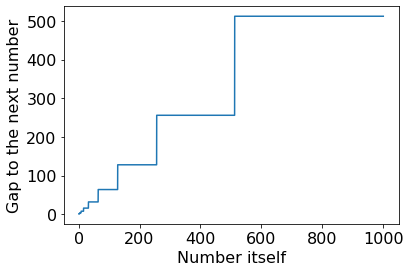

In [23]:
x = np.linspace(1,1000,100000)
spacing = 2**np.floor(np.log2(x))
plt.plot(x, spacing);
plt.xlabel("Number itself");
plt.ylabel("Gap to the next number");

In [25]:
2**-52 # this is the spacing at 1.0

2.220446049250313e-16

In [26]:
1.0 + 1e-20 == 1.0

True

In [27]:
0.3 - 0.2 - 0.1

-2.7755575615628914e-17

The steps get bigger, but the trend is a straight line. In other words, if we zoom out we see that the spacing size is _proportional to the number itself_. 

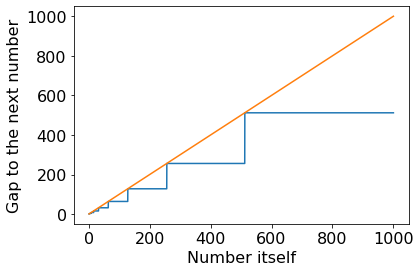

In [24]:
plt.plot(x, spacing)
plt.plot(x,x);
plt.xlabel("Number itself");
plt.ylabel("Gap to the next number");

We can also look on a log-log scale

In [ ]:
plt.loglog(x,spacing)
plt.loglog(x,x);
plt.xlabel("Number itself");
plt.ylabel("Gap to the next number");

Going back to our original example:

In [ ]:
0.3-0.2-0.1

- Let's assume some rounding occurred at the end, i.e. 52 bits after the decimal point. 
- Then we'd expect things to be wrong on the order of 

In [ ]:
2**(-52)*(0.1)

In [ ]:
2**-52

#### Take-home message about roundoff errors (!!)

The error in representing a number $\approx$ the number itself $\times \, 10^{-16}$

## Order of operations (10 min)

Consider the following:

In [35]:
1e16+1+1 == 1+1+1e16

False

????????

Ok... let's break it down.

In [31]:
1 + 1 + 1e16 == 1e16 # makes sense

False

In [32]:
1e16 + 1 + 1 == 1e16 # ????

True

In [33]:
1e16 + 1 + 1 +1+1+1+1+1+1+1+1+1 == 1e16

True

Ok, so the first one is the weird one. We now understand the above, given our new knowledge. The spacing between $10^{16}$ and the next largest number must be more than 2, so when 1 is added to $10^{16}$ we round back down to $10^{16}$.

What's happening here is that we do operations from left to right. So when we first do 1+1 we get 2. And I picked $10^{16}$ on purpose so that the spacing is more than 2 but less than 4. So when we add 2 to $10^{16}$ we do get far enough to round _up_ to the next number. In other words, the order of operations doesn't matter on paper, but it can matter in code due to floating point issues. 

We can check our reasoning by adding on the right side with parentheses

In [36]:
1e16 + (1+1) == 1e16

False

For kicks:

In [38]:
x = 1e16
for i in range(100_000):
    x = x + 1
x == 1e16

True

We can make it look even more disturbing for big numbers...

In [39]:
1e40 + 1000000000000000000 == 1e40

True

Or small numbers...

In [42]:
1 + 1e-20 == 1

True

Very abbreviated version of this lecture: "you have 16 digits of precision to work with".

**(begin optional)** By the way, what _is_ the spacing at $10^{16}$? We need to find the larest power of 2 that is less than $10^{16}$, which happens to be

In [43]:
2.0**53 

9007199254740992.0

In [44]:
# make it easier to read
'%g' % 2.0**53

'9.0072e+15'

Ok this looks good. So now we just need to do $2^{53}\times 2^{-52}=2$. So the spacing is exactly 2. I guess we round down when we add 1! We can also test this:

In [45]:
1e16 + 1 == 1e16

True

In [46]:
1e16 + 1.0000001 == 1e16

False

**(end optional)**

## log-sum-exp (15 min)

Let's consider logistic regression with one feature and no intercept, so that `w` is just a number. The loss function is :

In [48]:
def loss_lr_1D(w, x, y):
    return np.sum(np.log(1 + np.exp(-y*w*x)))


n = 100
x = np.random.randn(n)
x[1:10] *= 1e5
w = np.random.randn()
y = np.random.choice([-1,+1], size=n)

loss_lr_1D(w,x,y)

/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


inf

What we are doing here?

$$f(w) =  \sum_{i=1}^n \log \left( 1+ \exp(-y_iwx_i) \right) $$

The key is that we're computing $\log(1+\exp(z))$ and getting an overflow when $z\gg 1$. 

(Note: when doing the optimization, we only really need the gradient of the loss, so this isn't a completely realistic concern. But it happens for real in related problems.)

But when $z\gg1$ we can say $1+\exp(z)\approx \exp(z)$ and in that case  

$$\log(1+\exp(z))\approx \log(\exp(z)) = z$$

We can try it...

In [59]:
def log_1_plus_exp(z):
    return np.log(1+np.exp(z))

def log_1_plus_exp_safe(z):
    if z > 100:
        return z
    else:
        return log_1_plus_exp(z)

In [60]:
print(log_1_plus_exp(0))
print(log_1_plus_exp_safe(0))

0.6931471805599453
0.6931471805599453


In [56]:
print(log_1_plus_exp(1000))
print(log_1_plus_exp_safe(1000))

inf
inf


/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [53]:
print(log_1_plus_exp(110.))
print(log_1_plus_exp_safe(110.))

110.0
110.0


This is cool! We combined math + CS + our brains and got better results!

#### more take-home messages

- By combining an understanding of floating point errors and math, we can write better code.
- This is one (of many) reasons why we use libraries like sklearn rather than implementing things ourself. Other reasons: speed, edge cases, updates over time, less likely to contain a bug.


#### (optional) Moving to $d>1$ and multi-class

- When $d>1$ not much changes, except that your $z$ above is actually a dot product of a $w$-vector and an $x$-vector, so getting big numbers in there starts to be a much bigger problem. The above is then even more important. 
- Imagine $d=1000000$. Even if these numbers look like random noise (both positive and negative, cancelling each other out) by the central limit theorem their sum will grow like $\sqrt{n}$ and eventually overflow will be a problem. You only need to get to $z=1000$ before problems hit.
- When the number of classes change then things change more substantially. In particular with $K$ classes the $\log(1+\exp(z))$ flavour changes to

$$\log\left(\sum_{k=1}^K \exp(z_k)\right)$$

In that case we play a different trick which is to pull out the max $z_k$. More on this in lab 2!

## (optional) Inverting matrices (5 min)

Sometime we take the inverse of a matrix. I have seen it happen.

Key point: _this is almost always a bad idea!_

- If you actually need the inverse, then you must compute it
- But in real situations you almost always need to solve $Ax=b$ given some $b$
- In this case, use a solve function to compute this directly, rather than going to $x=A^{-1}b$.

In [62]:
A = np.random.rand(3,3) # random 3x3 matrix
b = np.random.rand(3)

x1 = npla.inv(A) @ b

In [63]:
x1

array([ 3.75901497,  4.16954844, -5.13845011])

In [64]:
x2 = npla.solve(A, b)

In [65]:
x2

array([ 3.75901497,  4.16954844, -5.13845011])

In [66]:
np.allclose(x1,x2) # looks good

True

In [67]:
n = 250
A = np.vander(np.random.rand(n))
b = np.random.rand(n)

y1 = npla.inv(A) @ b

In [68]:
y2 = npla.solve(A,b)

In [69]:
np.allclose(y1,y2)

False

In [70]:
np.max(y1-y2)

2.0090805554183255e+117

What happened??

Well, we're not really going to go into detail here. But, basically, just don't compute the inverse if you don't have to...